# Fermi Orbit Altitude History

### Robert Cameron, February 2018

In [1]:
from astropy.table import Table, Column
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import datetime as dt
import re
%matplotlib notebook

/Users/rac/anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
path = "/Users/rac/Documents/GLAST/"
# input file = history listing of TLE orbit parameter records for Fermi
tlefile = path+"FGST-TLE.txt"

#path2 = "/Users/rac/Documents/GLAST/ISOC/LATmetrics/Hubble-TLE/FGST-TLE2/"
#tlefile = path2+"FGST.tle.txt"

# write ASCII tabular file of Fermi orbit history
outfile = path+"ISOC/LATmetrics/orbit/orbit-history2.txt"
h1="Year      Orbit MeanMot(o/d) MMdot Period(s) SemiMajor(km) Alt  "
h2="Inclin   Eccen     RAAN   MeanAnom ArgPer PrecRate PrecPer(d)\n"
h = h1 + h2   # 14 variables per line
fo = open(outfile, 'w')
fo.write(h)

outfmt1 = "{0:10.5f} {1:5d} {2:9.6f} {3:8.2e} {4:8.3f} {5:8.3f} {6:7.3f} "
outfmt1 = "{0:10.5f} {1:5d} {2:9.6f} {3:s} {4:8.3f} {5:8.3f} {6:7.3f} "
outfmt2 = "{0:7.4f} {1:9.4e} {2:8.4f} {3:8.4f} {4:8.4f} {5:8.5f} {6:6.3f}\n"

In [3]:
# TLE Line 1
# Column  Description
# ======  ===========
# 01      Line Number of Element Data = 1
# 03-07   Satellite Number (FGST = 33053)
# 08      Classification (U = Unclassified)
# 10-11   International Designator (Last two digits of launch year) (FGST = 08)
# 12-14   International Designator (Launch number of the year) (FGST = 029)
# 15-17   International Designator (Piece of the launch) (FGST = "A  ")
# 19-20   Epoch Year (Last two digits of year)
# 21-32   Epoch (Day of the year and fractional portion of the day) (123.56789012)
# 34-43   First Time Derivative of the Mean Motion ( .67890123 =  .00000NNN)
# 45-52   Second Time Derivative of Mean Motion (decimal point assumed) ( 67890-2 =  00000-0)
# 54-61   BSTAR drag term (decimal point assumed) ( 5678901 =  NNNNN-N)
# 63      Ephemeris type (generally = 0)
# 65-68   Element number ( NNN)
# 69      Checksum (Modulo 10) (Letters, blanks, periods, plus signs = 0; minus signs = 1)

# TLE Line 2
# Column  Description
# ======  ===========
# 01      Line Number of Element Data = 2
# 03-07   Satellite Number (FGST = 33053)
# 09-16   Inclination [Degrees] (FGST = 25.58NN degrees)
# 18-25   Right Ascension of the Ascending Node [Degrees] (890.2345 = NNN.NNNN)
# 27-33   Eccentricity (decimal point assumed) (7890123, FGST = 001NNNN)
# 35-42   Argument of Perigee [Degrees] (567.9012 = NNN.NNNN)
# 44-51   Mean Anomaly [Degrees] (456.8901 = NNN.NNNN)
# 53-63   Mean Motion [Revs per day] (34.67890123, FGST = 15.NNNNnnnn)
# 64-68   Revolution number at epoch [Revs] (45678 = NNNNN)
# 69      Checksum (Modulo 10)

r1 = '^1(.{17})(\d{2})(.{12}) (.{13}) (\d{5})-(\d{1})  (\d{5})[-+](\d{1}) (\d{1}) (.{4})(\d{1})'
r1 = '^1(.{17})(\d{2})(.{12}) (.{9})'
r2 = '^2 33053 (.{8}) (.{8}) (.{7}) (.{8}) (.{8}) (.{11})(.{5})(\d{1})'
p1 = re.compile(r1)
p2 = re.compile(r2)

In [4]:
fy = []
orb = []
MM = []
MMdot = []
PerS = []
semi = []
alt = []
inc = []
ecc = []
RAAN = []
MeanAnom = []
ArgPer = []
prec = []
PrecP = []

In [5]:
def TLE1_calc(line1):
    m1 = p1.match(line1)
#    m1 = re.match(r1,line1)
    year = int(m1.group(2))
    doy = float(m1.group(3))
    MMdot.append(m1.group(4))
    ylen = (365, 366)[bool(year % 4)]
    fy.append(round(year + 2000 + doy/ylen,6))
#    print(m1.group(4))

In [6]:
R_earth = 6378
pi = 3.14159265359
GM = 398600.44  # km^3 s^-2 (Wertz 1978)
    
def TLE2_calc(line2):
    m2 = p2.match(line2)
    inc.append(float(m2.group(1)))
    RAAN.append(float(m2.group(2)))
    ecc.append(float(m2.group(3))/1.0e7)
    ArgPer.append(float(m2.group(4)))
    MeanAnom.append(float(m2.group(5)))
    MM.append(float(m2.group(6)))
    orb.append(int(m2.group(7)))
    PerS.append(86400.0/float(MM[-1]))
    semimajor = (GM*(PerS[-1]/2/pi)**2.0)**0.333333333333   # km
    semi.append(round(semimajor,4))
    alt.append(semi[-1] - R_earth)    # km
    ecc_term = (1.0-ecc[-1]**2.0)**2.0
    inc_term = -2.06474e14 * np.cos(inc[-1]*pi/180)
    prec_rate = inc_term /(ecc_term * (semimajor**3.5))  # deg/day
    prec.append(round(prec_rate,5))
    PrecP.append(round(abs(360/prec_rate),3))     # days
    outlist1 = (fy[-1],orb[-1],MM[-1],MMdot[-1],PerS[-1],semi[-1],alt[-1])
    outlist2 = (inc[-1],ecc[-1],RAAN[-1],MeanAnom[-1],ArgPer[-1],prec[-1],PrecP[-1])
    outstr1 = outfmt1.format(*outlist1)
    outstr2 = outfmt2.format(*outlist2)
    fo.write(outstr1+outstr2)
#    print (ecc[-1], inc[-1], PrecP[-1])

In [7]:
# read regular ASCII tabular file of Fermi 2-line TLE records

one = ""
two = ""
need = 1
prev = {}
row = 0
badrows = 0
rows1 = 0
rows2 = 0
rows12 = 0

with open(tlefile,'r') as ft:
    for line in ft:
        line = line.rstrip()
        if " 33053" not in line:
            badrows += 1
            continue
        if "1 33053U 08029A   " in line:
            need = 2
            one = line
            rows1 += 1
        if "2 33053 " in line:
            need = 1
            two = line
            rows2 += 1
        if (one and two):
            rows12 += 1
            if one not in prev:
                TLE1_calc(one)
                TLE2_calc(two)
                row += 1
            prev[one] = 1
            one = ""
            two = ""
            
print (row,"unique TLEs read from TLE history file:",badrows, rows1, rows2, rows12)

4022 unique TLEs read from TLE history file: 7430 5546 5546 5546


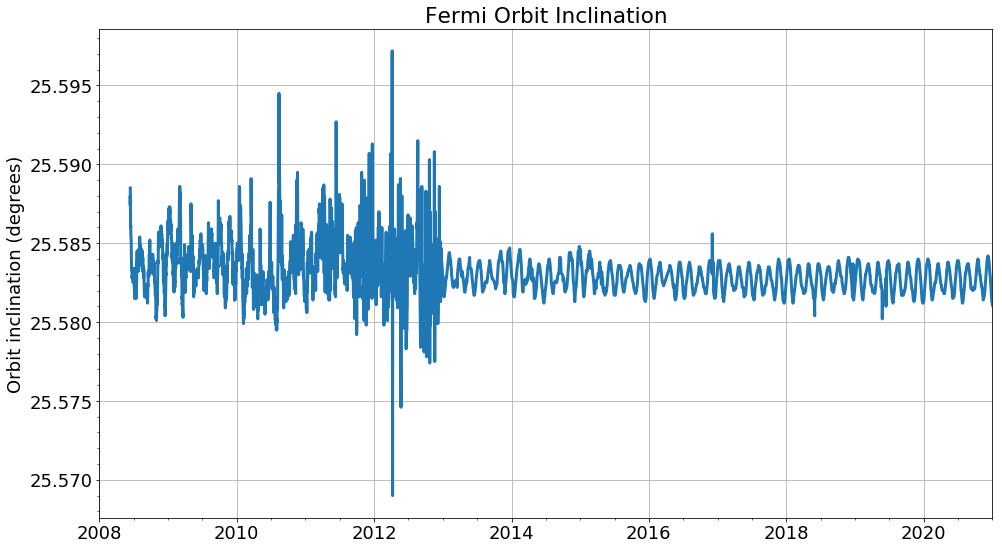

In [8]:
# plot the Fermi orbit inclination

plt.figure(figsize = [16, 9])
plt.rc('font', size = 18)
plt.ylabel('Orbit inclination (degrees)')
plt.title('Fermi Orbit Inclination')
plt.xlim(2008,2021)
#plt.ylim(20,30)
plt.tick_params(axis = 'both', which = 'major')
plt.tick_params(axis = 'both', which = 'minor')
plt.minorticks_on()
plt.grid(which='major')
plt.ticklabel_format(useOffset=False)
plt.plot(fy, inc, '', lw=3)

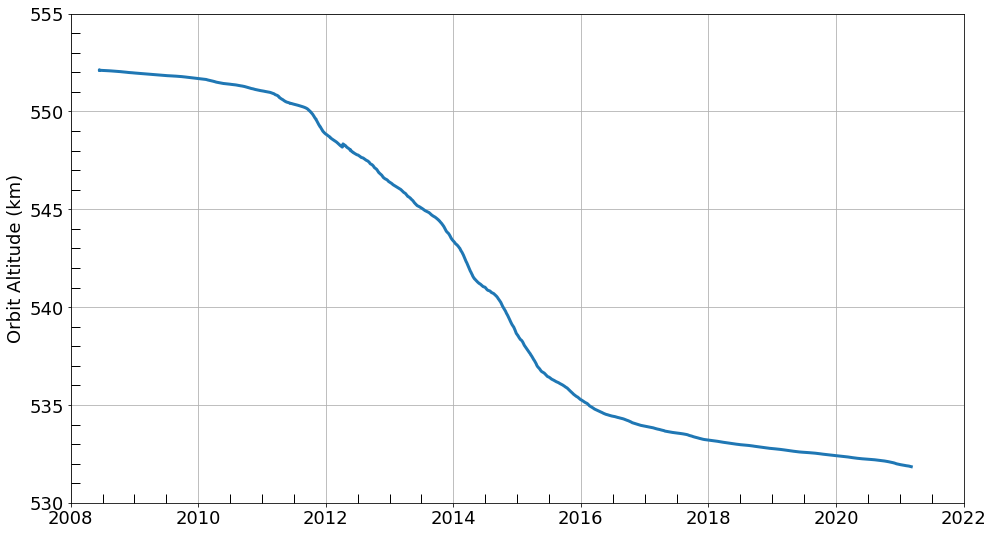

In [9]:
# plot the Fermi orbit altitude
plt.figure(figsize = [16, 9])
plt.rc('font', size = 18)
plt.ylabel('Orbit Altitude (km)')
plt.xlim(2008,2022)
plt.ylim(530,555)
plt.tick_params(axis = 'both', which = 'major')
plt.tick_params(which='minor', length=9, width=1, direction='in')
#plt.tick_params(axis = 'both', which = 'minor')
plt.minorticks_on()
plt.grid(which='major')
plt.ticklabel_format(useOffset=False)
plt.plot(fy, alt, '', lw=3)

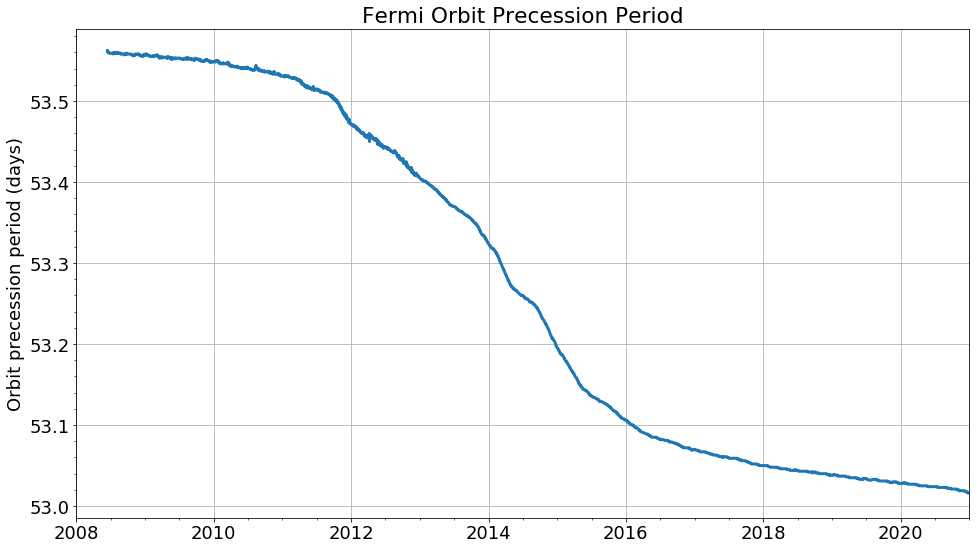

In [10]:
# plot the Fermi orbit precession period

plt.figure(figsize = [16, 9])
plt.rc('font', size = 18)
plt.ylabel('Orbit precession period (days)')
plt.title('Fermi Orbit Precession Period')
plt.xlim(2008,2021)
#plt.ylim(20,30)
plt.tick_params(axis = 'both', which = 'major')
plt.tick_params(axis = 'both', which = 'minor')
plt.minorticks_on()
plt.grid(which='major')
plt.ticklabel_format(useOffset=False)
plt.plot(fy, PrecP, '', lw=3)

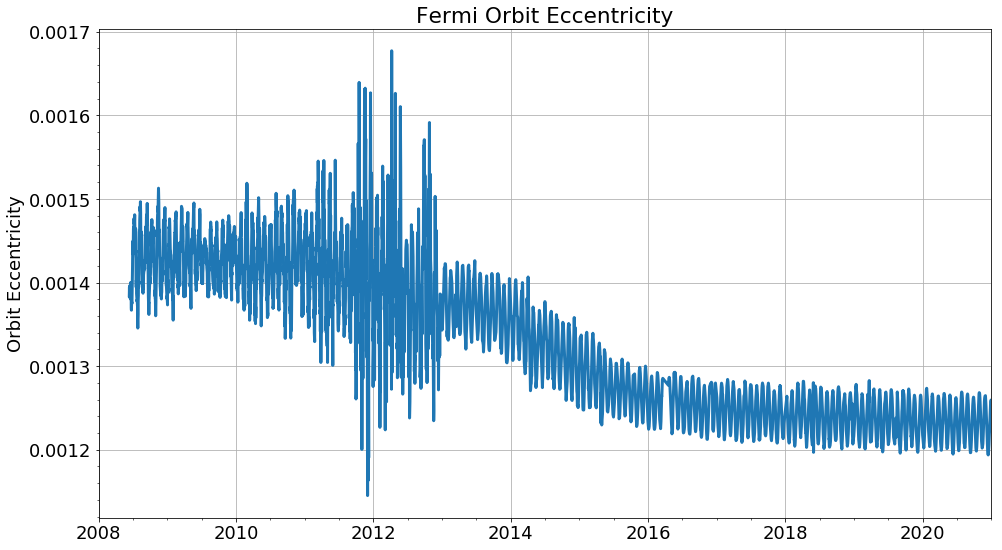

In [11]:
# plot the Fermi orbit eccentricity

plt.figure(figsize = [16, 9])
plt.rc('font', size = 18)
plt.ylabel('Orbit Eccentricity')
plt.title('Fermi Orbit Eccentricity')
plt.xlim(2008,2021)
plt.tick_params(axis = 'both', which = 'major')
plt.tick_params(axis = 'both', which = 'minor')
plt.minorticks_on()
plt.grid(which='major')
plt.ticklabel_format(useOffset=False)
plt.plot(fy, ecc, '', lw=3)

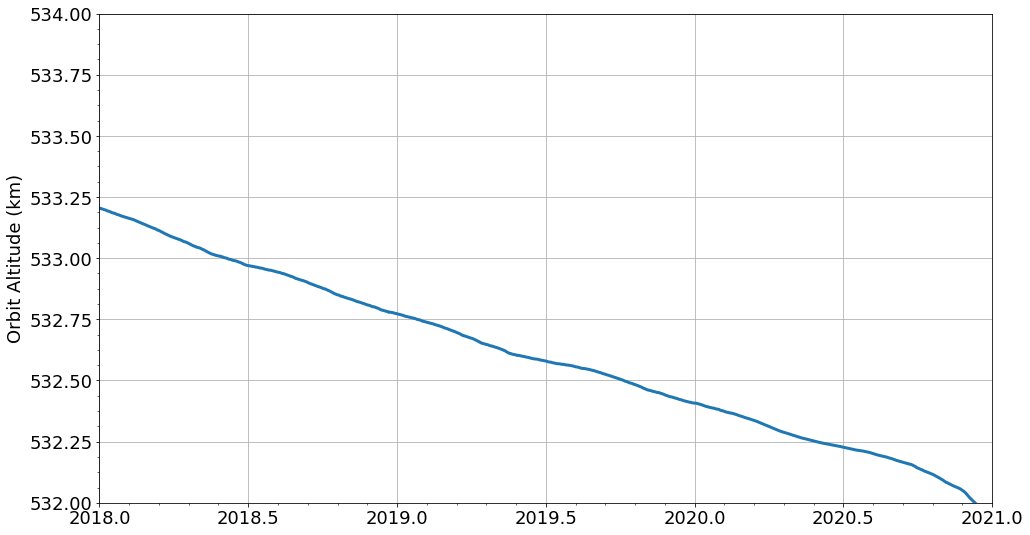

In [12]:
# plot the Fermi orbit altitude
plt.figure(figsize = [16, 9])
plt.rc('font', size = 18)
plt.ylabel('Orbit Altitude (km)')
plt.xlim(2018,2021)
plt.ylim(532,534)
plt.tick_params(axis = 'both', which = 'major')
plt.tick_params(axis = 'both', which = 'minor')
plt.minorticks_on()
plt.grid(which='major')
plt.ticklabel_format(useOffset=False)
plt.plot(fy, alt, '', lw=3)

In [13]:
plt.savefig(path+"ISOC/LATmetrics/orbit/alt2020.png")
fo.close()

<Figure size 432x288 with 0 Axes>

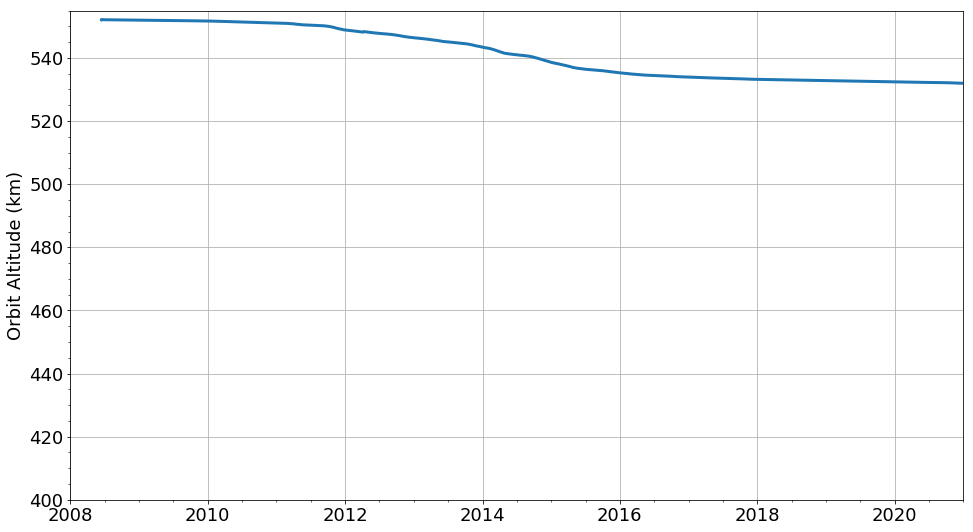

In [14]:
# plot the Fermi orbit altitude
plt.figure(figsize = [16, 9])
plt.rc('font', size = 18)
plt.ylabel('Orbit Altitude (km)')
plt.ylim([400,555])
plt.xlim([2008,2021])
plt.tick_params(axis = 'both', which = 'major')
plt.tick_params(axis = 'both', which = 'minor')
plt.minorticks_on()
plt.grid(which='major')
plt.ticklabel_format(useOffset=False)
plt.plot(fy, alt, '', lw=3)

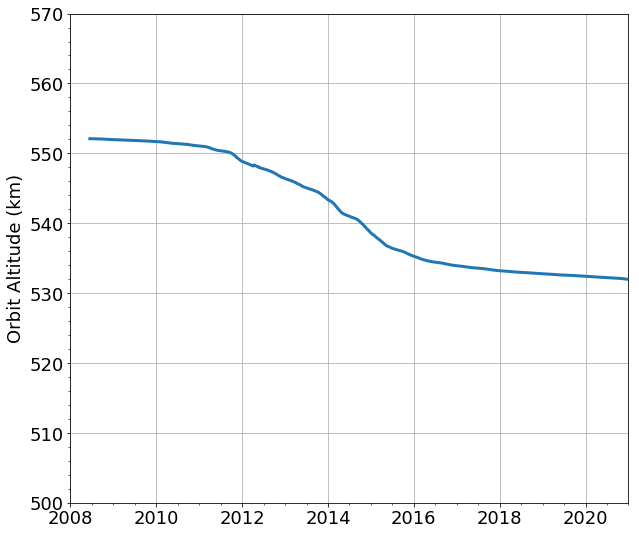

In [15]:
# plot the Fermi orbit altitude
plt.figure(figsize = [10, 9])
plt.rc('font', size = 18)
plt.ylabel('Orbit Altitude (km)')
plt.ylim([500,570])
plt.xlim([2008,2021])
plt.tick_params(axis = 'both', which = 'major')
plt.tick_params(axis = 'both', which = 'minor')
plt.minorticks_on()
plt.grid(which='major')
plt.ticklabel_format(useOffset=False)
plt.plot(fy, alt, '', lw=3)

# Overlay Fermi and Hubble orbit altitude history

In [16]:
path = "/Users/rac/Documents/GLAST/ISOC/LATmetrics/Hubble-TLE/"
# input file = history listing of TLE orbit parameter records for Fermi
#infile = path+"yy-doy-p.txt"  # obsolete
infile = path + "2020-y-doy-mm.txt"

# read the ASCII data file

cols = ['y','doy','motion','period']
sdf = pd.read_csv(infile,names=cols, delim_whitespace=True)
y = sdf['y']
doy = sdf['doy']
m = sdf['motion']
p = sdf['period']

FileNotFoundError: File b'/Users/rac/Documents/GLAST/ISOC/LATmetrics/Hubble-TLE/2020-y-doy-mm.txt' does not exist

In [ ]:
ylen = y % 4
ylen.where(ylen == 0, other=365, inplace=True)
ylen.where(ylen > 0, other=366, inplace=True)
ylen

hfy = (y + doy/ylen).tolist()

In [ ]:
# calculate orbit altitude from orbit Period (Wertz 1978)
R_earth = 6378
pi = 3.14159265359
GM = 398600.44  # km^3 s^-2 (Wertz 1978)
hsemimajor = (GM*(p/2/pi)**2.0)**0.333333333333   # km
halt = (hsemimajor - R_earth).tolist()    # km

In [ ]:
# plot the Hubble orbit altitude
plt.figure(figsize = [16, 9])
plt.rc('font', size = 18)
plt.ylabel('Hubble Orbit Altitude (km)')
plt.xlim(1990,2021)
#plt.ylim(538,540)
plt.tick_params(axis = 'both', which = 'major')
plt.tick_params(axis = 'both', which = 'minor')
plt.minorticks_on()
plt.grid(which='major')
plt.ticklabel_format(useOffset=False)
plt.plot(hfy, halt, '.', lw=3,label = 'HST Orbit Altitude')
plt.plot([1990.3,1996.4,2000.8,2009.1,2013.5,2021],[560,540,560,540,560,540],'-x',color='r',label='Solar Min and Max')
plt.quiver([1993.94,1997.13,1999.98,2002.19,2009.38],[579,584,589,564,554],[0,0,0,0,0],[5,5,5,5,5],width=.005,label='Servicing Missions')
plt.legend()

In [ ]:
# plot the Hubble orbit altitude
plt.figure(figsize = [16, 9])
plt.rc('font', size = 18)
plt.ylabel('Orbit Altitude (km)')
plt.xlim(1990,2021)
#plt.ylim(538,540)
plt.tick_params(axis = 'both', which = 'major')
plt.tick_params(axis = 'both', which = 'minor')
plt.minorticks_on()
plt.grid(which='major')
plt.ticklabel_format(useOffset=False)
plt.plot(hfy, halt, '.', lw=3,label = 'HST Orbit Altitude')
plt.plot(fy, alt, '-',lw=3, label = 'Fermi Orbit Altitude')
plt.plot([1990.3,1996.4,2000.8,2009.1,2013.5,2021],[560,540,560,540,560,540],'-x',color='r',label='Solar Min and Max')
plt.quiver([1993.94,1997.13,1999.98,2002.19,2009.38],[579,584,589,564,554],[0,0,0,0,0],[5,5,5,5,5],width=.005,label='HST Service Missions')
plt.legend()
plt.tick_params(which='major', length=10, width=1, direction='in')
plt.tick_params(which='minor', length=5, width=1, direction='in')

In [ ]:
# plot the Hubble orbit altitude
plt.figure(figsize = [16, 9])
plt.rc('font', size = 18)
plt.ylabel('Orbit Altitude (km)')
plt.xlim(2018,2021)
plt.ylim(532,534)
plt.tick_params(axis = 'both', which = 'major')
plt.tick_params(axis = 'both', which = 'minor')
plt.minorticks_on()
plt.grid(which='major')
plt.ticklabel_format(useOffset=False)
haltm6 = [x - 5.98 for x in halt]
plt.plot(hfy, haltm6, '-', lw=3,label = 'HST orbit altitude change rate')
plt.plot(fy, alt, '-',lw=3, label = 'Fermi orbit altitude change rate')
plt.legend()

In [ ]:
len(fy),len(alt),len(hfy),len(halt)

In [ ]:
fy[-1],fy[-577],alt[-1],alt[-577]

In [ ]:
hfy[-1],hfy[-1456],halt[-1],halt[-1456]

In [ ]:
fslope=(alt[-577]-alt[-1])/(fy[-577]-fy[-1])
fslope

In [ ]:
hslope=(halt[-1456]-halt[-1])/(hfy[-1456]-hfy[-1])
hslope

In [ ]:
5.98/(fslope-hslope)